# Spectral analysis

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True :
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2) # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.40:8787/status,
Dashboard: http://10.148.0.40:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.40:41415,Workers: 0
Dashboard: http://10.148.0.40:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# LOAD

In [9]:
root_dir = "/home1/datawork/mdemol/GDP"
zarr_argos = os.path.join(root_dir, "argos_spectra.zarr")
zarr_gps = os.path.join(root_dir, "gps_spectra.zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsa = xr.open_zarr(zarr_argos).persist()

_______
# Spectra

Text(0.5, 1.0, 'Argos')

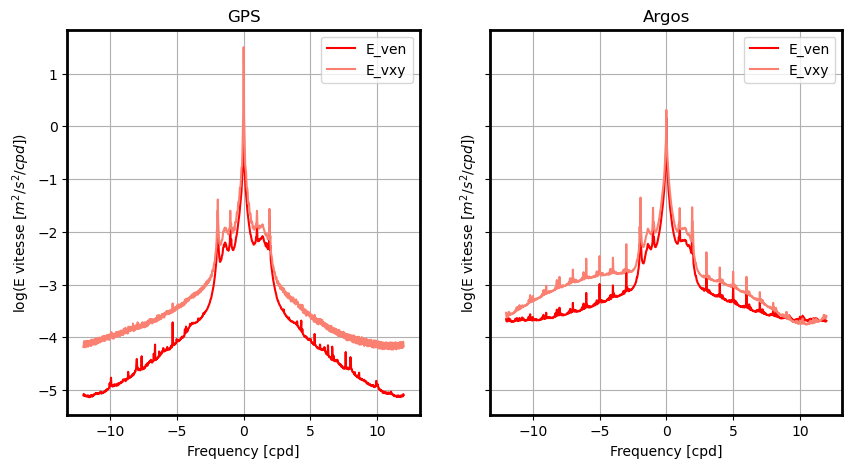

In [10]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax =ax.flatten()

np.log10(dsg.E_ven.mean(["lon_bins", "lat_bins"])).plot(label = 'E_ven', color='red', ax=ax[0])
np.log10(dsg.E_vxy.mean(["lon_bins", "lat_bins"])).plot(label = 'E_vxy', color='salmon', ax=ax[0])

np.log10(dsa.E_ven.mean(["lon_bins", "lat_bins"])).plot(label = 'E_ven', color='red', ax=ax[1])
np.log10(dsa.E_vxy.mean(["lon_bins", "lat_bins"])).plot(label = 'E_vxy', color='salmon', ax=ax[1])
for a in ax: 
    a.grid()
    a.set_xlabel('Frequency [cpd]')
    a.set_ylabel(r'log(E vitesse $[m^2/s^2/cpd]$)')
    a.legend()
    
ax[0].set_title('GPS')
ax[1].set_title('Argos')

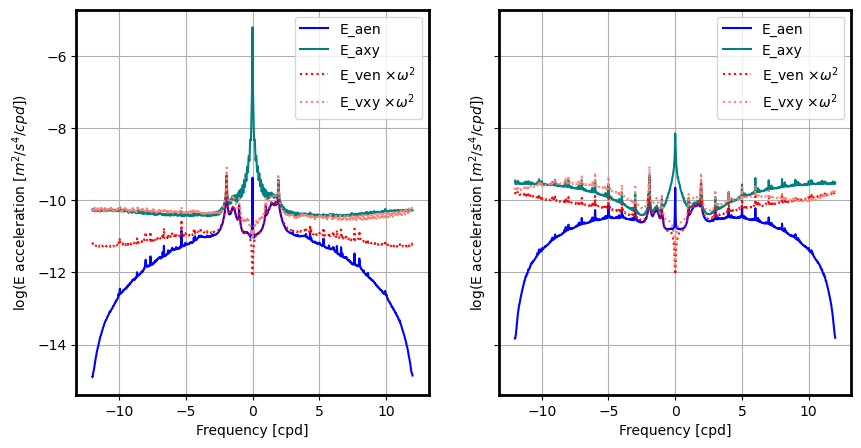

In [12]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax =ax.flatten()

np.log10(dsg.E_aen.mean(["lon_bins", "lat_bins"])).plot(label = 'E_aen', color='b', ax=ax[0])
np.log10(dsg.E_axy.mean(["lon_bins", "lat_bins"])).plot(label = 'E_axy', color='teal', ax=ax[0])
np.log10(dsg.E_venw2.mean(["lon_bins", "lat_bins"])).plot(label = r'E_ven $ \times \omega^2$', color='red', ls=':', ax=ax[0])
np.log10(dsg.E_vxyw2.mean(["lon_bins", "lat_bins"])).plot(label = r'E_vxy $ \times \omega^2$', color='salmon', ls=':', ax=ax[0])

np.log10(dsa.E_aen.mean(["lon_bins", "lat_bins"])).plot(label = 'E_aen', color='b', ax=ax[1])
np.log10(dsa.E_axy.mean(["lon_bins", "lat_bins"])).plot(label = 'E_axy', color='teal', ax=ax[1])
np.log10(dsa.E_venw2.mean(["lon_bins", "lat_bins"])).plot(label = r'E_ven $ \times \omega^2$', color='red', ls=':', ax=ax[1])
np.log10(dsa.E_vxyw2.mean(["lon_bins", "lat_bins"])).plot(label = r'E_vxy $ \times \omega^2$', color='salmon', ls=':', ax=ax[1])

for a in ax: 
    a.grid()
    a.set_xlabel('Frequency [cpd]')
    a.set_ylabel(r'log(E acceleration $[m^2/s^4/cpd]$)')
    a.legend()

In [13]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
